# Linear SSM Validation

## Model Structure

### Transition
$$
\underbrace{\left(\begin{array}{c}
z_{1 t} \\
z_{2 t} \\
\dot{z}_{1 t} \\
\dot{z}_{2 t}
\end{array}\right)}_{\mathbf{z}_t}=\underbrace{\left(\begin{array}{cccc}
1 & 0 & \Delta & 0 \\
0 & 1 & 0 & \Delta \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{array}\right)}_{\mathbf{A}} \underbrace{\left(\begin{array}{c}
z_{1, t-1} \\
z_{2, t-1} \\
\dot{z}_{1, t-1} \\
\dot{z}_{2, t-1}
\end{array}\right)}_{\mathbf{z}_{t-1}}+\mathbf{w}_t, \mathbf{w}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{Q})
$$

### Observation
$$
\underbrace{\left(\begin{array}{c}
y_{1, t} \\
y_{2, t}
\end{array}\right)}_{\mathbf{a}_t}=\underbrace{\left(\begin{array}{cccc}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{array}\right)}_{\mathbf{C}} \underbrace{\left(\begin{array}{c}
z_{1 t} \\
z_{2 t} \\
\dot{z}_{1 t} \\
\dot{z}_{2 t}
\end{array}\right)}_{\mathbf{z}_t}+\mathbf{v}_t, \mathbf{v}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{R})
$$

<!-- $$
\begin{aligned}
\mathbf{Q} & =\left(\begin{array}{cccc}
\frac{q_1 \Delta^3}{3} & 0 & \frac{q_1 \Delta^2}{2} & 0 \\
0 & \frac{q_2 \Delta^3}{3} & 0 & \frac{q_2 \Delta^2}{2} \\
\frac{q_1 \Delta^2}{2} & 0 & q_1 \Delta & 0 \\
0 & \frac{q_2 \Delta^2}{2} & 0 & q_2 \Delta
\end{array}\right) \\
\mathbf{R} & =\left(\begin{array}{cc}
\sigma_1^2 & 0 \\
0 & \sigma_2^2
\end{array}\right)
\end{aligned}
$$ -->

## Data Generation

In [1]:
import matplotlib.pyplot as plt
import torch
from sample_control import SampleControl
from state_space_model import StateSpaceModel

In [2]:
def generate_data():
    # Code from Lapo

    # Test Kalman Filter with synthetic data
    # create ground truth data
    T = 15
    start_Y = 10
    end_Y = 9
    step_Y = (start_Y - end_Y) / T

    gt_seq_X = [x + 1 for x in range(10, 10 + T)]

    gt_seq_Y = [start_Y]
    for y in range(T - 2):
        gt_seq_Y.append(gt_seq_Y[y] - step_Y)
    gt_seq_Y.append(end_Y)

    # create observed data
    observations_Y = [
        11.8,
        10.2,
        9.7,
        9.85,
        8.5,
        10.1,
        9.6,
        10.8,
        8.0,
        8.3,
        9.3,
        8.2,
        10.1,
        9.9,
        6.5,
    ]
    observations_X = [
        9.0,
        11.8,
        12.2,
        12.3,
        12.8,
        15.3,
        15.8,
        17.7,
        18.1,
        19.5,
        20.1,
        20.6,
        22.2,
        23.0,
        24.0,
    ]
    observations_seq = []
    for obs_idx in range(T):
        observations_seq.append([observations_X[obs_idx], observations_Y[obs_idx]])
    observations_seq = torch.tensor(observations_seq).unsqueeze(0)

    return gt_seq_X, gt_seq_Y, observations_seq.permute(1, 0, 2)

In [3]:
sample_control = SampleControl.training_defaults()

In [4]:
gt_seq_X, gt_seq_Y, observations_seq = generate_data()

In [5]:
a_dim = 2
z_dim = 4
K = 2  # dummy

# Initial state

mu_init = torch.FloatTensor([8, 10, 1, 0])
sigma_init = 0.5 * torch.eye(z_dim)

# Noise

## Process noise
diag_Q = 0.05

## Measurement noise
diag_R = 0.25

# Time step
delta = 0.5

In [6]:
mat_A = torch.Tensor([[1, 0, delta, 0], [0, 1, 0, delta], [0, 0, 1, 0], [0, 0, 0, 1]])
mat_A_K = mat_A.unsqueeze(0).repeat(K, 1, 1)

mat_C = torch.Tensor([[1, 0, 0, 0], [0, 1, 0, 0]])
mat_C_K = mat_C.unsqueeze(0).repeat(K, 1, 1)

mat_Q = diag_Q * torch.eye(z_dim)
mat_R = diag_R * torch.eye(a_dim)

In [7]:
state_space_model = StateSpaceModel(
    a_dim=a_dim,
    z_dim=z_dim,
    K=K,
    fix_matrices=True,
    initial_state_mean=mu_init,
    initial_state_covariance=sigma_init,
)
state_space_model.mat_A_K = mat_A_K
state_space_model.mat_C_K = mat_C_K
state_space_model.mat_Q = mat_Q
state_space_model.mat_R = mat_R

In [8]:
# Kalman filter and smoother
(
    filter_means,
    filter_covariances,
    filter_next_means,
    filter_next_covariances,
    mat_As,
    mat_Cs,
    filter_as,
) = state_space_model.kalman_filter(
    observations_seq,
    sample_control=sample_control,
    learn_weight_model=True,
)
means, covariances, zs, as_ = state_space_model.kalman_smooth(
    observations_seq,
    filter_means,
    filter_covariances,
    filter_next_means,
    filter_next_covariances,
    mat_As,
    mat_Cs,
    sample_control=sample_control,
)

In [9]:
filter_means[0].shape

torch.Size([1, 4])

In [11]:
print(filter_means.shape)
print(means.shape)

torch.Size([15, 1, 4])
torch.Size([15, 1, 4])


In [16]:
observations_seq.shape

torch.Size([15, 1, 2])

## Visualizing Result

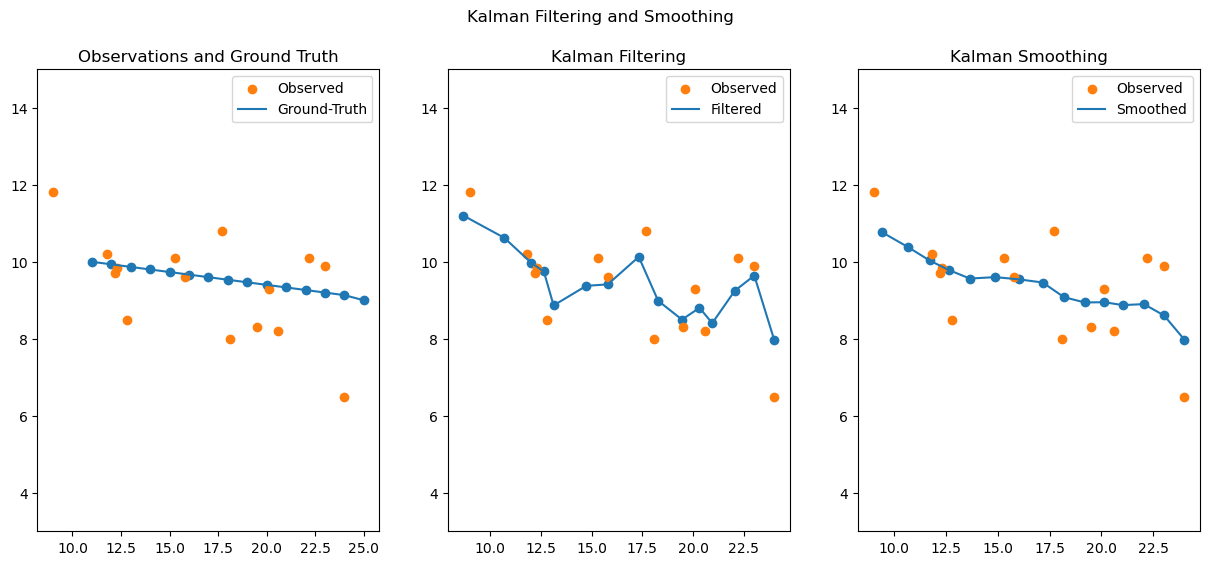

In [19]:
# plot all figures together
fig_sum, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
fig_sum.suptitle("Kalman Filtering and Smoothing")
ax1.scatter(gt_seq_X, gt_seq_Y)
ax1.scatter(observations_seq[:, 0, 0], observations_seq[:, 0, 1], label="Observed")
ax1.plot(gt_seq_X, gt_seq_Y, label="Ground-Truth")
ax1.set_ylim([3, 15])
ax1.legend(loc="upper right")
ax1.title.set_text("Observations and Ground Truth")

ax2.scatter(
    filter_means[:, :, 0].detach().numpy(), filter_means[:, :, 1].detach().numpy()
)
ax2.scatter(observations_seq[:, 0, 0], observations_seq[:, 0, 1], label="Observed")
ax2.plot(
    filter_means[:, :, 0].detach().numpy(),
    filter_means[:, :, 1].detach().numpy(),
    label="Filtered",
)
ax2.set_ylim([3, 15])
ax2.legend(loc="upper right")
ax2.title.set_text("Kalman Filtering")

ax3.scatter(means[:, :, 0].detach().numpy(), means[:, :, 1].detach().numpy())
ax3.scatter(observations_seq[:, 0, 0], observations_seq[:, 0, 1], label="Observed")
ax3.plot(means[:, :, 0].detach().numpy(), means[:, :, 1].detach().numpy(), label="Smoothed")
ax3.set_ylim([3, 15])
ax3.legend(loc="upper right")
ax3.title.set_text("Kalman Smoothing")

# Reference with FilterPy

In [15]:
from filterpy.kalman import KalmanFilter

In [16]:
kalman_filter = KalmanFilter(dim_x=z_dim, dim_z=a_dim)
kalman_filter.x = mu_init.numpy().reshape(z_dim, 1)
kalman_filter.P = sigma_init.numpy()
kalman_filter.F = mat_A.numpy()
kalman_filter.H = mat_C.numpy()
kalman_filter.Q = mat_Q.numpy()
kalman_filter.R = mat_R.numpy()

In [17]:
filter_means_gt, filter_covs_gt = kalman_filter.batch_filter(observations_seq.numpy())[
    :2
]
means_gt = kalman_filter.rts_smoother(filter_means_gt, filter_covs_gt)[0]

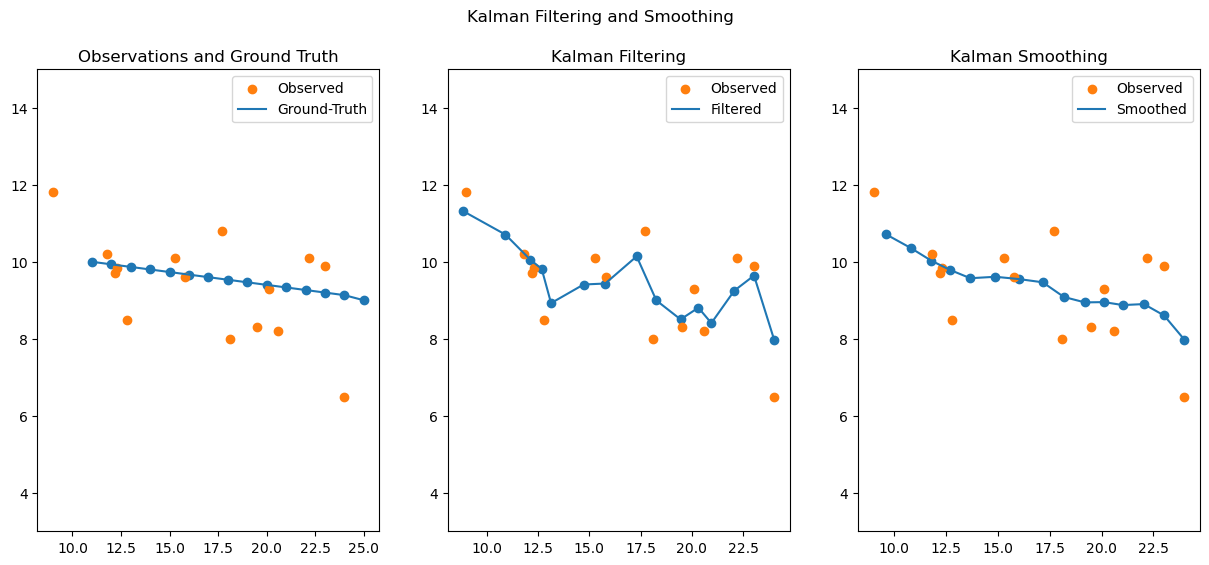

In [18]:
# plot all figures together
fig_sum, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
fig_sum.suptitle("Kalman Filtering and Smoothing")
ax1.scatter(gt_seq_X, gt_seq_Y)
ax1.scatter(observations_seq[:, 0, 0], observations_seq[:, 0, 1], label="Observed")
ax1.plot(gt_seq_X, gt_seq_Y, label="Ground-Truth")
ax1.set_ylim([3, 15])
ax1.legend(loc="upper right")
ax1.title.set_text("Observations and Ground Truth")

ax2.scatter(filter_means_gt[:, 0], filter_means_gt[:, 1])
ax2.scatter(observations_seq[:, 0, 0], observations_seq[:, 0, 1], label="Observed")
ax2.plot(filter_means_gt[:, 0], filter_means_gt[:, 1], label="Filtered")
ax2.set_ylim([3, 15])
ax2.legend(loc="upper right")
ax2.title.set_text("Kalman Filtering")

ax3.scatter(means_gt[:, 0], means_gt[:, 1])
ax3.scatter(observations_seq[:, 0, 0], observations_seq[:, 0, 1], label="Observed")
ax3.plot(means_gt[:, 0], means_gt[:, 1], label="Smoothed")
ax3.set_ylim([3, 15])
ax3.legend(loc="upper right")
ax3.title.set_text("Kalman Smoothing")